# Load packages

In [24]:
from bs4 import BeautifulSoup
from bson.json_util import dumps
import json
import matplotlib.pyplot as plt

# NLTL packages
import nltk
from nltk.corpus import wordnet, stopwords, words
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer

import pymongo
import re
import string
import sys
from textblob import TextBlob
import tweepy
from urllib import request
from wordcloud import WordCloud, STOPWORDS

# Retrieve the top CEO twitter handles

In [5]:
def get_ceo_handles():
    '''
        Retrieves the top CEO twitter handles from ceoworld.biz
    '''
    
    # Retrieve URL
    url = "https://ceoworld.biz/2018/01/02/top-ceos-and-business-leaders-on-twitter-you-should-be-following/"

    # Get HTTP response
    response = request.urlopen(url)

    # Convert response to string
    html = response.read().decode('utf-8')

    # Parse string
    soup = BeautifulSoup(html, "html.parser")

    # Append CEO handles to a list
    ceo_handles = []
    tr = (soup.findAll('tr'))
    for td in tr:
        tag = td.findAll('td')[1].string
        if tag and tag[0] == "@":
            ceo_handles.append(tag)

    # Return twitter handles
    return(ceo_handles)

# Create list of CEO handles

In [28]:
# Calls ceo_handles function to save a list of ceos handles
ceos = get_ceo_handles()

# Remove invalid twitter handles
ceos.remove('@tonyfernandes')
ceos.remove('@MarkZuckerbergF')
ceos.remove('@iancsmatthews')
ceos.remove('@DannyG_inkster')
ceos.remove('@DCSebJ')
ceos.remove('@JackParsons_CEO')

# Add valid twitter handles
ceos.append('@finkd')
ceos.append('@_DannyGibson')
ceos.append('@JacksonRParsons')
ceos[:10]

['@elonmusk',
 '@richardbranson',
 '@tim_cook',
 '@mcuban',
 '@Lord_Sugar',
 '@JohnLegere',
 '@jack',
 '@levie',
 '@marissamayer',
 '@satyanadella']

# Extract Twitter data

In [29]:
def get_tweets(user_list):
    '''
        Extracts data from twitter
    '''
    #get new token information
    CONSUMER_KEY = "XXXX"
    CONSUMER_SECRET = "XXXX"
    OAUTH_TOKEN = 'XXXX'
    OAUTH_SECRET = "XXXX"

    # Authorization to consumer key and consumer secret
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)

    # Access to user's access key and access secret
    auth.set_access_token(OAUTH_TOKEN, OAUTH_SECRET)

    # Calling api
    api = tweepy.API(auth, wait_on_rate_limit=True)

    # 50 tweets to be extracted
    tweet_list = []
    for username in user_list:
        tweets = (api.user_timeline(screen_name=username, count = 50, include_rts = False, tweet_mode = 'extended'))

        for tweet in tweets:
            # Appending tweets to the empty array tmp
            tweet_list.append(tweet._json)

    # Printing the tweets
    return(tweet_list)

In [32]:
# Get tweets of ceos
tweet_list = get_tweets(ceos)

In [33]:
# Print tweets
print(tweet_list[:1])

[{'created_at': 'Tue Jun 02 02:54:03 +0000 2020', 'id': 1267650659320500226, 'id_str': '1267650659320500226', 'full_text': 'Off Twitter for a while', 'truncated': False, 'display_text_range': [0, 23], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}, 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 44196397, 'id_str': '44196397', 'name': 'Elon Musk', 'screen_name': 'elonmusk', 'location': '', 'description': '', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 35503507, 'friends_count': 86, 'listed_count': 53302, 'created_at': 'Tue Jun 02 20:12:29 +0000 2009', 'favourites_count': 5699, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': True, 'statuses_count': 11162, 'lang':

# Save Twitter data to MongoDB database

In [34]:
def save_to_DB (DBname, DBcollection, data):
    '''
        Saves the data extracted from twitter to the mongodb database
    '''
    # Connect to database server 
    client = pymongo.MongoClient('localhost', 27017)
    
    # save the results in a database collection
    #   change names to lowercase because they are not case sensitive
    #   and remove special characters like hashtags and spaces (other special characters may also be forbidden)
    DBname = DBname.lower()
    DBname = DBname.replace('#', '')
    DBname = DBname.replace(' ', '')
    DBcollection = DBcollection.lower()
    DBcollection = DBcollection.replace('#', '')
    DBcollection = DBcollection.replace(' ', '')

    # Save database and collection parameters
    db = client[DBname]
    collection = db[DBcollection]

    # Add data to the database
    collection.insert_many(data)
    print("Saved", len(data), "documents to DB collection", DBname, DBcollection)

In [35]:
# Calls the save_to_DB function to save data to mongoDB tweets database
save_to_DB("tweets", "ceos", tweet_list)

Saved 3372 documents to DB collection tweets ceos


In [36]:
# Print tweets
def print_tweets(l):
    for tweet in l:
        print('\nDate:    ', tweet['created_at'])
        print('From:    ', tweet['user']['name'])
        print('Message: ', tweet['full_text'])
        if tweet['place'] != None:
            print('Place:   ', tweet['place']['full_name'])

In [37]:
# Print tweets
print_tweets(tweet_list)


Date:     Tue Jun 02 02:54:03 +0000 2020
From:     Elon Musk
Message:  Off Twitter for a while

Date:     Mon Jun 01 18:59:21 +0000 2020
From:     Elon Musk
Message:  @PPathole Starship is the key to making life multiplanetary &amp; protecting the light of consciousness

Date:     Mon Jun 01 11:19:34 +0000 2020
From:     Elon Musk
Message:  @mharrisonair Well said

Date:     Mon Jun 01 10:54:30 +0000 2020
From:     Elon Musk
Message:  @DjKeyWay Definitely not right that the other officers were charged with nothing. What message does this send in general to officers who stand by while another does wrong? #JusticeForGeorge

Date:     Mon Jun 01 10:27:19 +0000 2020
From:     Elon Musk
Message:  @scale_banana @engineers_feed Where’s the banana!?

Date:     Sun May 31 19:46:25 +0000 2020
From:     Elon Musk
Message:  Nine years later https://t.co/CS1LbPLN2N

Date:     Sun May 31 18:25:58 +0000 2020
From:     Elon Musk
Message:  @NASASpaceflight Must be due to relativistic aging 😉

Date:   

Message:  Maybe it’s time to invest in a telescope 🤩https://t.co/kom9S7BAim

Date:     Wed May 20 16:58:51 +0000 2020
From:     John Legere
Message:  Make sure you follow @NevilleRay, you’ll be blown away to see how #5GforGood is done! https://t.co/wuXIKwB1Nb

Date:     Wed May 20 03:14:49 +0000 2020
From:     John Legere
Message:  I’m hooked on this show! Can’t wait for season two, who else is excited? https://t.co/zMjAgm0eaL

Date:     Wed May 20 00:00:34 +0000 2020
From:     John Legere
Message:  My favorite apron, custom made. 😉 https://t.co/q1v8lAMk8m

Date:     Mon May 18 23:10:11 +0000 2020
From:     John Legere
Message:  Even after cleaning out my closet I think I have enough clothes to do #MagentaMonday for another decade! https://t.co/q6FLeH9ejb

Date:     Mon May 18 00:29:31 +0000 2020
From:     John Legere
Message:  This sounds so cool 🤩 I think I might almost be convinced to finally join Animal Crossing. https://t.co/u1yWAHh6Gu

Date:     Sun May 17 22:59:07 +0000 2020
Fro

Date:     Wed May 13 18:32:07 +0000 2020
From:     Michael Dell
Message:  Congratulations to the 30 @DellTechPartner leaders selected as @CRN 2020 Women of the Channel, including 5 in the Power 100. Really proud of all the work you do on behalf of our @DellTech partners. #WOTC20 
https://t.co/K1Ztj39hSM

Date:     Wed May 13 17:13:32 +0000 2020
From:     Michael Dell
Message:  Proud of the generosity our @DellTech team members. As of today, they have raised over $1.3M for non-profits supporting COVID-19 response. #DellLove
https://t.co/zrVwbL2v95

Date:     Tue May 12 19:34:56 +0000 2020
From:     Michael Dell
Message:  Appreciate how organizations are stepping up to address remote learning challenges. This virtual classroom launched by @DellFdn partner @NeprisApp is one great example: https://t.co/6CZ8rEBiDI

Date:     Sun May 10 01:35:13 +0000 2020
From:     Michael Dell
Message:  Congratulations #DellMedFirstClass on your great achievement. 👩🏽‍⚕️👨‍⚕️We need you now more than ever. T

Message:  I'm keynoting the XC virtual conference this week. Head to.the link to register and join me as we talk about how we will prepare our family outlook for a new future. #COVID19 #Biohacking #Life #Kids #Education #Disruption 

https://t.co/fLwSzLaFzM https://t.co/0F40inY3AY

Date:     Fri May 15 16:41:26 +0000 2020
From:     Dave Asprey
Message:  Protocols are important. Why you should start (like now) ordering local &amp; small farm raised. Co-ops like #GrassRootsCoop are solving this processing problem. 

#Trump has ordered the plants opened, despite ongoing #COVID19 safety concerns. https://t.co/LqvwlTanmH via @HuffPost

Date:     Fri May 15 00:19:03 +0000 2020
From:     Dave Asprey
Message:  If you didn't catch this special episode on #BulletproofRadio please listen. #SmallFarms matter and this is why. #MeatIndustry #COVID19
#coronavirus #farmtofork #ChefsForAmerica #NYC to #LA
https://t.co/mQaBRYV5RI

Date:     Wed May 13 16:23:13 +0000 2020
From:     Dave Asprey
Message:  


Date:     Sun May 24 23:00:36 +0000 2020
From:     Thubten
Message:  @fondalo Amen!
Place:    Vancouver, WA

Date:     Sat May 23 17:51:14 +0000 2020
From:     Thubten
Message:  This ballet school is such an important and valuable community resource. Please contribute: 1500 Angels to Save Westside School of Ballet. 

https://t.co/YEUxGXpqkD

Date:     Tue May 19 15:48:09 +0000 2020
From:     Thubten
Message:  @zosegal Come to Vancouver!

Date:     Sat May 16 17:20:43 +0000 2020
From:     Thubten
Message:  I’m glad they turned out for you. I’m making another batch right now! https://t.co/Buq07agyGM
Place:    Vancouver, WA

Date:     Fri May 15 22:39:33 +0000 2020
From:     Thubten
Message:  @turoczy @GIPHY @piepdx @instagram In the same way that Queen Elizabeth is a descendent of the Prophet Mohammed? Yes!

https://t.co/P2OrCy6wrj

Date:     Tue May 12 03:28:20 +0000 2020
From:     Thubten
Message:  @HeerJeet Oliver Stone’s documentary on Netflix, Untold History of the United States la

Date:     Tue Jun 02 20:14:16 +0000 2020
From:     Debra Ruh
Message:  Please stay safe. #AXSChat https://t.co/ftNe9dM0Fd
Place:    Virginia, USA

Date:     Tue Jun 02 20:13:55 +0000 2020
From:     Debra Ruh
Message:  I believe that #BlackLivesMatter @LaMondre_P but how many #black people have to be #murdered for us to wake up &amp; realize that #WhiteSupremacists have infiltrated our #policedepartment. Senseless violence against people due to skin color must stop.  #PoliceReformNow #GeorgeFloyd https://t.co/mjOoYlbe5p
Place:    Virginia, USA

Date:     Tue Jun 02 20:09:52 +0000 2020
From:     Debra Ruh
Message:  @KimPossible1809 so much about this #GeorgeFloyd being murdered only because he was black. We must stop the violence against #AfricanAmericans and all #black &amp; #brown people. #BlackLivesMatter  #PoliceBrutality #GeorgeFloydWasMurdered #AXSChat. #RacismIsAPublicHealthCrisis https://t.co/14Njuisdd0
Place:    Virginia, USA

Date:     Tue Jun 02 20:06:50 +0000 2020
From:     D

From:     Joseph Steinberg
Message:  A3: Ensuring that remote data is safe (and backed up)… 

Adopting plans for securely returning to the office after remote working…

@CIOStraightTalk #Stinsights #OneHCL #CyberSecurity #COVID19 #Coronavirus

Date:     Tue Jun 02 23:39:41 +0000 2020
From:     Mike Kawula
Message:  @ravcchaudhary @noahkagan There are several online. 

If you Google "RIASEC Theory" That's an inexpensive one used in a few schools. 

Strengths Finder is another. I believe if you buy the book you get a code still to take the test. Great book &amp; I love the authors story.

Date:     Tue Jun 02 23:26:44 +0000 2020
From:     Mike Kawula
Message:  @jackmaopro Pleasure speaking to you tonight

Impressive mission as a High School Senior with your nonprofit. I wish you the best &amp; reach out if I can assist. 

Definitely follow @Austen &amp; consider @LambdaSchool when you begin looking. Don't put yourself in debt 🙏

Good Luck ❤️

Date:     Tue Jun 02 23:15:54 +0000 2020
From

Date:     Fri Apr 24 16:29:23 +0000 2020
From:     Rod Berger PsyD
Message:  2. The previous tweet was about #PostCovid. Returning to normal? I would say we will have to redefine what #Normal or a #NewNormal is and looks like. #ChildrenAndCOVID19 https://t.co/aNT6J3TjeS

Date:     Fri Apr 24 16:24:29 +0000 2020
From:     Rod Berger PsyD
Message:  1. Don’t forget the basics. Whether a child enters a physical classroom or digital one, we have to be prepared and supportive of the social emotional (#SEL) composite of each child and subsequent interaction with other students and teachers. #ChildrenAndCOVID19 https://t.co/aNT6J3TjeS

Date:     Mon Jun 01 21:00:17 +0000 2020
From:     Spencer Rascoff
Message:  6/ Be kind to each other. ☮️

Date:     Mon Jun 01 21:00:17 +0000 2020
From:     Spencer Rascoff
Message:  5/ My “Office Hours” podcast with @vanjones68 from two years ago resonates. 🎙️
https://t.co/AZvHDDIGA2

Date:     Mon Jun 01 21:00:16 +0000 2020
From:     Spencer Rascoff
Message: 

From:     JM Alvarez-Pallete
Message:  How a 5G coronavirus conspiracy spread across Europe. Financial Times. https://t.co/PmgTusyjEs

Date:     Thu Apr 16 18:33:43 +0000 2020
From:     JM Alvarez-Pallete
Message:  Gracias a todos los que lo habéis hecho posible. https://t.co/W3HAWAuMRT

Date:     Thu Apr 16 09:05:00 +0000 2020
From:     JM Alvarez-Pallete
Message:  @Fundacion_SERES @fundacionTef @Virginiagalvin @JoseMaPalomares @Pacomesonero @Ethic_ @pacopolo @AsocDIRSE @mananaempieza @marcosgonzalezm Muchas gracias a @Fundacion_SERES , a #FranciscoRomán y a @Marietajurgal por el diálogo y la oportunidad de participar.

Date:     Wed Apr 15 21:51:50 +0000 2020
From:     JM Alvarez-Pallete
Message:  @antonigr @revistatelos A ti

Date:     Wed Apr 15 21:15:20 +0000 2020
From:     JM Alvarez-Pallete
Message:  Si los obstáculos son grandes, tan solo queda saltar más alto. / vía 
@AitorGoy https://t.co/PMF7f4N3lz

Date:     Wed Apr 15 21:00:05 +0000 2020
From:     JM Alvarez-Pallete
Messag

From:     Josef Holm
Message:  @Ramcas42 ATM the answer, sadly, is yes. There is currently no path to widespread success of #blockchain without #BTC.

Date:     Sun May 17 06:00:30 +0000 2020
From:     Josef Holm
Message:  @amibendavid Bad.

Date:     Sun May 17 05:51:44 +0000 2020
From:     Josef Holm
Message:  @LunarCRUSH @oh_hey_dan @joevezz @jonfarjo @iwooten @Cameron__Giles @kfarjo @AlonGoren @adamlevy265 @MatiGreenspan @TitosVodka Clearly vegans have no home at @LunarCRUSH

Date:     Sun May 17 02:24:43 +0000 2020
From:     Josef Holm
Message:  @oh_hey_dan @LunarCRUSH @joevezz @jonfarjo @iwooten @Cameron__Giles @kfarjo @AlonGoren @adamlevy265 @MatiGreenspan @TitosVodka Titos &amp; steak go really well together!

Date:     Sun May 17 01:03:19 +0000 2020
From:     Josef Holm
Message:  @LunarCRUSH @joevezz @jonfarjo @oh_hey_dan @iwooten @Cameron__Giles @kfarjo @AlonGoren @adamlevy265 @MatiGreenspan I never take my eyes off #BTC and my drink is @TitosVodka 🥂

Date:     Sat May 16 23:

Message:  Have you ever shared your credit card information or SSN or other banking information through email/social networks/messaging apps?

Date:     Mon Aug 27 01:35:39 +0000 2018
From:     Shashwat Pradhan
Message:  It's time to address artificial intelligence's ethical problems https://t.co/PNLQ5iIceR #AI #ML

Date:     Tue Jul 31 23:50:57 +0000 2018
From:     Shashwat Pradhan
Message:  Can Electronauts help make #VR more social? https://t.co/dHhlGza4Lp

Date:     Thu Jul 26 16:14:40 +0000 2018
From:     Shashwat Pradhan
Message:  Google Cloud built for #DevOps
1 Data to guide decisions
2 Shared fate 
3 Transparency 
4 Postmortem
#GoogleNext18 https://t.co/yB7DHFmsyk
Place:    San Francisco, CA

Date:     Thu Jul 26 16:10:49 +0000 2018
From:     Shashwat Pradhan
Message:  #GoogleNext18 https://t.co/2HvisaNjGu

Date:     Wed Jul 18 16:15:25 +0000 2018
From:     Shashwat Pradhan
Message:  Design is the only thing holding mobile AR back https://t.co/rzuO0vAbtS #AR #AugmentedReality


From:     Dr. Ganapathi Pulipaka
Message:  Free Book: Gaussian Processes for #MachineLearning . #BigData #Analytics #DataScience #AI #IoT #IIoT #Python #RStats#JavaScript #ReactJS #GoLang #CloudComputing #Serverless #DataScientist #Books #Linux #Statistics #Programming #Coding #100DaysofCode 
https://t.co/shQIlSWu41 https://t.co/hT5Du3RCh2

Date:     Sun May 31 16:47:19 +0000 2020
From:     Dr. Ganapathi Pulipaka
Message:  Springer has Released 65 #DataScience #Books for Free. #BigData #Analytics #IoT #IIoT #Python #RStats #JavaScript #ReactJS #CloudComputing #Serverless #Linux #Mathematics #Statistics #Programming #Coding #100DaysofCode 
https://t.co/Z8LAKDSgBS https://t.co/4ivJmUNOUY

Date:     Sun May 31 16:44:24 +0000 2020
From:     Dr. Ganapathi Pulipaka
Message:  The Seven Sins of Machine Learning by @maier_ak. #BigData #Analytics #DataScience #AI #MachineLearning #IoT #IIoT #Python #RStats #TensorFlow #Java #JavaScript #ReactJS #CloudComputing #Serverless #DataScientist #Linux #

From:     Juliet Funt
Message:  Complimentary Webinar on WhiteSpace this Friday for Training Magazine. And it's on my birthday!  Send your whole team:   https://t.co/88XLDX3kmj

Date:     Tue Dec 04 13:22:00 +0000 2018
From:     Juliet Funt
Message:  Do you ever check email while with family and then fall prey to an "email shadow" that then follows you around for hours as you obsess about the thing you wish you had not seen?

Date:     Tue Dec 04 05:30:13 +0000 2018
From:     Juliet Funt
Message:  Today I spoke with a client who's assistant is a "task hoarder." A new term I will be running with. Are you collecting tasks and to-do's just to make your pike higher?

Date:     Fri Nov 30 13:11:29 +0000 2018
From:     Juliet Funt
Message:  Don't think I've shared here about our current adventure. We're running the company from the road, homeschooling the kids and traveling full time. Its great on the 4th month and we'll keep you posted!

Date:     Tue Nov 27 17:52:33 +0000 2018
From:     Ju

Message:  For @goldstar organizer partners, I'm happy to say that we are rapidly pulling together ways to raise money on the Goldstar platform for your organization. https://t.co/gEsE0vIDs3

Date:     Mon Mar 16 20:26:58 +0000 2020
From:     Jim McCarthy
Message:  MATH! https://t.co/iUpYFsGChX

Date:     Mon Mar 16 18:59:54 +0000 2020
From:     Jim McCarthy
Message:  Great! https://t.co/NGwYnw7FHV

Date:     Mon Mar 16 18:47:25 +0000 2020
From:     Jim McCarthy
Message:  @derektixx Thanks, Derek!

Date:     Mon Mar 16 16:56:05 +0000 2020
From:     Jim McCarthy
Message:  What I said to @goldstar customers on Friday. https://t.co/arBoWSR55S

Date:     Tue Jun 02 16:01:06 +0000 2020
From:     Mauro Biasolo
Message:  😂 https://t.co/NCtEn08meF

Date:     Mon Jun 01 21:48:21 +0000 2020
From:     Mauro Biasolo
Message:  In 2020 there are still teams trying to sell such projects #blockchain https://t.co/hOZrDLyKG0 v

Date:     Mon Jun 01 06:18:49 +0000 2020
From:     Mauro Biasolo
Message:  Se

Message:  @LiveaMemory @Abfabtravels @RoadtripC @carpediemeire @JeanetteJoy @BethFratesMD @MadHattersNYC @always5star @CourseCharted @jflorez Perfect list Doug 🙌 Adding peace and good health 🧡 Wishing you and your family a beautiful month ahead. https://t.co/9cQXgOSciW

Date:     Tue Jun 02 13:52:03 +0000 2020
From:     Suzi Day
Message:  @MiniWineGirl You are such an inspiration Rachel💖Keeping you in my thoughts and prayers🙏

Date:     Tue Jun 02 13:50:33 +0000 2020
From:     Suzi Day
Message:  @LoriMoreno I wish for peace 🙏Have a beautiful day Lori 💖 https://t.co/ocD2l0jaxQ

Date:     Tue Jun 02 13:49:48 +0000 2020
From:     Suzi Day
Message:  @RhonaFenton Hi Rhona. Hope you and the family are safe and well 💖

Date:     Tue Jun 02 13:49:29 +0000 2020
From:     Suzi Day
Message:  @TrueF1Fan Morning Brian ☕️☀️ https://t.co/dC8tq3T1mc

Date:     Tue Jun 02 13:48:56 +0000 2020
From:     Suzi Day
Message:  @JackConnie Morning Connie. Just ok here thank you. Have a wonderful Tuesday! https

From:     Javier CR
Message:  @McgallupSimon happy birthday. Best bass guitarist ever ! @thecure https://t.co/yeiDkUzyiy

Date:     Sun May 31 22:08:06 +0000 2020
From:     Javier CR
Message:  Son de estas cosas que no se entienden. El casco debería ser totalmente obligatorio. Me caí en bicicleta con casco y me salvó, aunque no pude evitar romperme 4 costillas y los metacarpianos. Cada vez que veo un patinete pienso que debería estar prohibido circular en muchos sitios https://t.co/qovPgfkTZk

Date:     Sun May 31 21:51:00 +0000 2020
From:     Javier CR
Message:  @juanmacastano No se puede decir más claro. Gracias @juanmacastano comparto 100% tu agradecimiento a Madrid. Es SIN DUDA la ciudad más integradora de España.

Date:     Sun May 31 21:33:01 +0000 2020
From:     Javier CR
Message:  🙉🙉🙉🙉 https://t.co/6i6bwWaVPL

Date:     Sun May 31 18:06:34 +0000 2020
From:     Javier CR
Message:  @rafa1984 🤣🤣🤣🤣

Date:     Sun May 31 18:05:03 +0000 2020
From:     Javier CR
Message:  @rafa1984 🤣🤣

# Retrieve tweets from database

In [6]:
def get_tweets_DB(dt):
    '''
        Retrieves tweets from mongoDB database
    '''
    # Get local mongo client
    client = pymongo.MongoClient('localhost', 27017)
    # Get database
    db = client.tweets
    # Get collection
    coll = db.ceos
    # Get tweets
    tweets = coll.find()
    
    # Appends tweets to a list from the date
    tweet_list = []
    for tweet in tweets:
        if tweet['created_at'][:10] == dt:
            tweet_list.append(tweet)
  
    # Returns list of tweets
    return tweet_list

In [7]:
# Saves tweets from database to variable tweets
date = 'Sun May 31'
tweets = get_tweets_DB(date)
tweets[:5]

[{'_id': ObjectId('5ed6ebdea6b81230e4df34a5'),
  'created_at': 'Sun May 31 19:46:25 +0000 2020',
  'id': 1267180654896254976,
  'id_str': '1267180654896254976',
  'full_text': 'Nine years later https://t.co/CS1LbPLN2N',
  'truncated': False,
  'display_text_range': [0, 16],
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [],
   'urls': [{'url': 'https://t.co/CS1LbPLN2N',
     'expanded_url': 'https://twitter.com/spacex/status/91925525999796224',
     'display_url': 'twitter.com/spacex/status/…',
     'indices': [17, 40]}]},
  'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_screen_name': None,
  'user': {'id': 44196397,
   'id_str': '44196397',
   'name': 'Elon Musk',
   'screen_name': 'elonmusk',
   'location': '',
   'description': '',
   'url': None,
   'entities': {'

# Create dictionary of CEOs and their tweets

In [13]:
def create_dict(l):
    '''
        Create dictionary of CEOs and their tweets
    '''
    d = {}
    for tweet in l:
        d[tweet['user']['name']] = ""
    for tweet in l:
        d[tweet['user']['name']] += tweet['full_text']
    return d
ceo_dict = create_dict(tweets)
ceo_dict

{'Elon Musk': 'Nine years later https://t.co/CS1LbPLN2N@NASASpaceflight Must be due to relativistic aging 😉@NASASpaceflight Brought home by same person who placed it there almost a decade ago@Rogozin @SpaceX @JimBridenstine @roscosmos @NASA Спасибо, сэр, ха-ха. Мы рассчитываем на взаимовыгодное и процветающее долгосрочное сотрудничество.\n- Elon@SpaceX @NASA @AstroBehnken @Astro_Doug Congratulations Bob &amp; Doug on docking &amp; hatch opening on @Space_Station!@TeslaGong @TeslaTested Sure@TeslaTested ProbablyDragon docks with @Space_Station in ~3 hours https://t.co/MxGRr4xuXS@NASA @SpaceX @AstroBehnken @Astro_Doug @Space_Station Dragonship Endeavor',
 'Mark Cuban': "We can do that interview at @burgerim_westend again or any place you want to support.  Let's Go! And Everyone follow my guy @ezforshort.  Man has a HUGE ♥️\n #DallasTogether #DallasStrong https://t.co/iVdSeNh9uPGreat people , new friends, great music and  the @burgerim_westend Veggie Burger and Onion Rings were incredible

# Tokenize CEO tweets

In [25]:
# Tokenizes words for CEO
def tokenize(ceos, ceo):
    '''
        Stems, cleans, and tokenizes CEO tweets
    '''
    # Separate all words into list
    tk = TweetTokenizer() 
    token = tk.tokenize(ceos[ceo])  
    
    # Convert all tokens to lowercase
    token = [token.lower() for token in token]

    # Get stop words
    stop_words = set(stopwords.words('english'))
    punctuation = string.punctuation
    
    # Stemming and Lemmatizing word
    wnl = WordNetLemmatizer()
    pst = PorterStemmer()

    # Remove stopwords, punctuation, and non-english words
    filtered_token = []
    for word in token:
        if word not in stop_words:
            if word not in string.punctuation:
                if 'https://' not in word:
                    word = pst.stem(word)
                    filtered_token.append(word)
        
    # Return list of filtered words
    return filtered_token

In [26]:
# Calls tokenize function with ceo
token = tokenize(ceo_dict, 'Elon Musk')
print(token[:50])

['nine', 'year', 'later', 'must', 'due', 'relativist', 'age', '😉', '@nasaspaceflight', 'brought', 'home', 'person', 'place', 'almost', 'decad', 'ago', '@rogozin', '@spacex', '@jimbridenstin', '@roscosmo', '@nasa', 'спасибо', 'сэр', 'ха-ха', 'мы', 'рассчитываем', 'на', 'взаимовыгодное', 'и', 'процветающее', 'долгосрочное', 'сотрудничество', 'elon', '@spacex', '@nasa', '@astrobehnken', '@astro_doug', 'congratul', 'bob', 'doug', 'dock', 'hatch', 'open', '@space_st', '@teslagong', '@teslatest', 'sure', '@teslatest', 'probablydragon', 'dock']


# Create word cloud

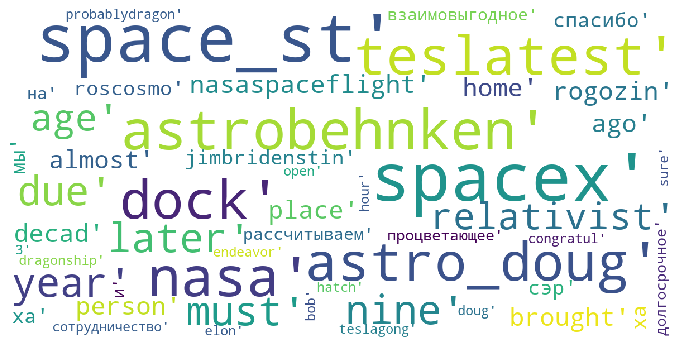

In [27]:
def generate_wordcloud(tk):
    '''
        Visualizes word data with wordcloud
    '''
    wordcloud = WordCloud(
            background_color='white',
            stopwords=set(stopwords.words('english')),
            max_words=100,
            max_font_size=40, 
            scale=3
    ).generate(str(tk))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()
generate_wordcloud(token)

# Get polarity scores

In [21]:
def create_sentiment_score(ceos):
    '''
        Uses TextBlob to create a dictionary of ceos and their corresponding polarity scores 
    '''
    # Iterates through the CEO keys and returns the polarity score
    blob_dict = {}
    for key in ceos:
        blob = TextBlob(ceos[key])
        polarity = round(blob.sentiment.polarity, 4)
        blob_dict[key] = polarity
        
    # Returns a dictionary of polarity scores
    return blob_dict

create_sentiment_score(ceo_dict)

{'Elon Musk': -0.0417,
 'Mark Cuban': 0.6473,
 'Lord Sugar': 0.0654,
 'Aaron Levie': -0.0538,
 'marissamayer': 1.0,
 'Sundar Pichai': -0.5556,
 'Larry Kim': -0.1,
 'Tamara McCleary': 0.05,
 'Thubten': -0.2,
 'Ashley Alexiss': 0.375,
 'MarceloClaure': 0.3327,
 'John Hall': 0.0417,
 'John Lincoln': 0.3,
 'Gurbaksh Singh Chahal': 0.2,
 'Mike Kawula': 0.2792,
 'Michael Brenner': -0.2,
 'Spencer Rascoff': 0.0591,
 'Danielle Morrill': 0.0743,
 'Peter Bordes': -0.081,
 'Rob Peters': 0.2333,
 'Dr. Ganapathi Pulipaka': 0.4667,
 'David R. Prasser': 0.2446,
 'MariAnne Vanella': 0.65,
 'david jones': 0.0,
 'Steve Zeitchik': 0.0,
 'Tim Jackson CAE': 0.1728,
 'Jon Ferrara': 0.1005,
 'Stephen Kelly': 0.295,
 'Jeremy Bloom': 0.0,
 'Javier CR': 0.5375,
 'ayah bdeir': -0.0125,
 'Helena Morrissey DBE': 0.2389}